<h1>TechSolutions – SQL Performance Analytics<h1>

###### **Author: Braulio HG**
###### **Date: 08/24/2025**

### **Table of Contents**

**1. Install Libraries**

**2. Import Main Libraries**

**3. Gemini API Configuration**

- 3.1. Function to Analyze Queries with Gemini

- 3.2. Connection Test

**4. Database Connection**

**5. Function to Explore Table Structures**

**6. Initial Inventory**

**7. Window Function Query**

- 7.1. My Version

- 7.2. Gemini Suggestion

- 7.3. Performance Comparison

**8. Common Table Expression (CTE) Query**

- 8.1. My Version

- 8.2. Gemini Suggestion

- 8.3. Performance Comparison

**9. View Creation Query**

- 9.1. My Version

- 9.2. Gemini Suggestion

- 9.3. Test Query

**10. Index Creation**

**11. Stored Procedure Creation**

- 11.1. My Version

- 11.2. Gemini Suggestion

- 11.3. Date Index Creation

**12. Summary of Changes**

**13. Restoration of Changes**

**1. Install Libraries.**

- psycopg2: The translator that allows Python to communicate with your PostgreSQL database.

- pandas: The Python spreadsheet, ideal for organizing and analyzing your data in tables.

- matplotlib and seaborn: The artists that help you create attractive visualizations for your data.

- sqlalchemy: The manager that connects Python to your database securely and efficiently

- google-generativeia: To use the gemini API


In [1]:
# install necessary libraries
%pip install psycopg2-binary pandas matplotlib seaborn 
%pip install sqlalchemy
%pip install google-generativeai 

**2. Import Main Libraries.**

In [2]:
# Import libraries
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time # for measuring execution time 
from sqlalchemy import create_engine
from sqlalchemy import text
# google libraries
import google.generativeai as genai # to use Google Gemini API
import textwrap # for formatting text output
from IPython.display import Markdown # for displaying markdown
import requests
import json

**3. Gemini API Configuration.**

In [3]:
# API connection
GEMINI_API_KEY = "" # private key
API_URL = "https://generativelanguage.googleapis.com/v1beta/models/gemini-2.0-flash:generateContent"

headers = {
    'Content-Type': 'application/json',
    'X-goog-api-key': GEMINI_API_KEY
}

print("Generative Language API v1beta configured")

Generative Language API v1beta configured


**3.1. Function to Analyze Queries with Gemini.**

In [4]:
def analyze_sql_query_with_gemini(query):
    """
    Analyze SQL query using Generative Language API REST endpoint
    """
    prompt = f"""
    You are a PostgreSQL optimization expert with 15 years of experience. 
    Analyze the following SQL CREATE VIEW query and provide:

    1. **Concise analysis**: Key suggestions for performance, readability, best practices
    2. **Potential issues**: Any problems or improvements needed  
    3. **Optimized version**: Improved SQL code if applicable

    Return response in Markdown format.

    QUERY TO ANALYZE:
    ```sql
    {query}
    ```
    """
    
    payload = {
        "contents": [
            {
                "parts": [
                    {
                        "text": prompt
                    }
                ]
            }
        ]
    }
    
    try:
        response = requests.post(API_URL, headers=headers, json=payload)
        response.raise_for_status()
        result = response.json()
    
        if 'candidates' in result and len(result['candidates']) > 0:
                text_response = result['candidates'][0]['content']['parts'][0]['text']
                return Markdown(text_response) # Display as Markdown
        else:
                return Markdown("No response content found")
    except Exception as e:
            return Markdown(f"Error calling API: {e}")

**3.2. Connection test.**

In [5]:
# code to test the connection to the API (prompt suggests by Google)
test_payload = {
    "contents": [
        {
            "parts": [
                {
                    "text": "Hello! Respond with 'API is working' if you can hear me."
                }
            ]
        }
    ]
}

try:
    response = requests.post(API_URL, headers=headers, json=test_payload)
    response.raise_for_status()
    
    result = response.json()
    if 'candidates' in result and len(result['candidates']) > 0:
        test_response = result['candidates'][0]['content']['parts'][0]['text']
        print(f"API Response: {test_response}")
    else:
        print("No response content")
        
except Exception as e:
    print(f"Failed: {e}")

API Response: API is working



**4. Database Connection.**

**Using SQLAlchemy instead of a driver like psycopg2 is justified for three main reasons:** 

**Abstraction**
It acts as an abstraction layer that allows you to write database-independent code. You can switch from PostgreSQL to MySQL without modifying the code, only the connection string.

**Efficiency**
It manages a connection pool. Instead of creating a new connection for each operation, SQLAlchemy reuses existing connections, saving time and reducing server load.

**Security**
It prevents SQL injection. SQLAlchemy uses parameterized queries that separate data from SQL code, ensuring that user input cannot maliciously alter queries.



In [6]:
# Database connection parameters
connection_params = {
    "host": "",
    "database": "techsolutionsdb",
    "user": "postgres",
    "password": "postgres",
    "port": "5432"
}

try:
    # connection to SQLAlchemy (for use with pandas)
    engine = create_engine(
        f'postgresql+psycopg2://{connection_params["user"]}:{connection_params["password"]}@{connection_params["host"]}:{connection_params["port"]}/{connection_params["database"]}'
    )

    with engine.connect() as connection:
        print("Connection successful!")
except Exception as e:
    print(f"Connection failed!: {e}")

Connection successful!


**5. Function to Explore Table Structures.**

In [7]:
def explore_table(table_name):
    query = f"SELECT * FROM {table_name} LIMIT 5"
    df = pd.read_sql(query, engine)
    print(f"\nStructure of {table_name}:")
    print(f"Files: {pd.read_sql(f'SELECT COUNT(*) FROM {table_name}', engine).iloc[0,0]}")
    display(df)
    print("\n" + "="*60) # Print a separator line to improve readability

tables = ['Departamentos', 'Categorias', 'Clientes', 'Vendedores', 'Productos', 'Ventas', 'DetalleVentas']
# Explore each table
for table in tables:
    explore_table(table)


Structure of Departamentos:
Files: 5


,departamentoid,nombre,descripcion,presupuestoanual,fechacreacion
0,1,Ventas,Departamento encargado de la gestión de ventas...,2140000.0,2023-01-15
1,2,Finanzas,Departamento encargado de la gestión financier...,3700000.0,2023-01-15
2,3,Recursos Humanos,Departamento encargado de la gestión del perso...,1500000.0,2023-01-15
3,4,Marketing,Departamento encargado de la promoción de prod...,250000.0,2023-01-15
4,5,TI,Departamento encargado de la infraestructura t...,400000.0,2023-01-15




Structure of Categorias:
Files: 10


,categoriaid,nombre,descripcion
0,1,Redes,Equipos de networking y comunicaciones
1,2,Seguridad,Soluciones de seguridad informática
2,3,Almacenamiento,Dispositivos de almacenamiento de datos
3,4,Móviles,Dispositivos móviles y smartphones
4,5,Gaming,Productos para gaming y entretenimiento




Structure of Clientes:
Files: 18


,clienteid,nombre,apellido,email,telefono,fecharegistro,activo
0,1,Ana,Gómez,ana.gomez@mail.com,555-1234,2024-01-20,True
1,2,Juan,Pérez,juan.perez@mail.com,555-5678,2024-02-10,True
2,3,Sofía,López,sofia.lopez@mail.com,555-9012,2024-03-05,True
3,4,Carlos,Rodríguez,carlos.rodriguez@mail.com,555-3456,2024-03-15,True
4,5,María,Fernández,maria.fernandez@mail.com,555-7890,2024-04-01,True




Structure of Vendedores:
Files: 5


,vendedorid,nombre,apellido,email,fechacontratacion,salariobase,departamentoid,activo
0,1,Manuel,Reyes,manuel.reyes@techsolutions.com,2023-03-01,35000.0,1,True
1,2,Silvia,Cruz,silvia.cruz@techsolutions.com,2023-04-10,36000.0,1,True
2,3,Antonio,Ortiz,antonio.ortiz@techsolutions.com,2023-05-15,34500.0,1,True
3,5,Roberto,Vega,roberto.vega@techsolutions.com,2023-07-25,35500.0,1,True
4,4,Braulio,Herrera,braulio.herrera@gtechsolutions.com,2023-06-20,37000.0,1,True




Structure of Productos:
Files: 20


,productoid,nombre,descripcion,preciobase,costobase,categoriaid,stock,fechacreacion,activo
0,1,Router Inalámbrico AX5400,Router de alto rendimiento para redes doméstic...,120.00,80.0,1,50,2024-01-05,True
1,2,Firewall Empresarial FWS-100,Dispositivo de seguridad perimetral para empre...,450.00,300.0,2,25,2024-01-10,True
2,3,SSD M.2 NVMe 1TB,Unidad de estado sólido de alta velocidad para...,95.00,65.0,3,150,2024-02-01,True
3,4,Smartphone Pro S20,Teléfono inteligente de gama alta con cámara a...,899.99,650.0,4,30,2024-02-15,True
4,5,Laptop Gaming G-Force,Ordenador portátil diseñado para gaming.,1500.00,1100.0,5,15,2024-03-01,True




Structure of Ventas:
Files: 40


,ventaid,clienteid,vendedorid,fechaventa,totalventa,estado
0,1,1,1,2024-02-15,99.0,Completada
1,2,2,2,2024-03-20,1600.0,Completada
2,3,3,3,2024-04-10,50.0,Completada
3,4,4,4,2024-04-25,120.0,Completada
4,5,5,5,2024-05-15,500.0,Completada




Structure of DetalleVentas:
Files: 47


,detalleventaid,ventaid,productoid,cantidad,preciounitario,subtotal
0,1,1,3,1,95.0,95.0
1,2,1,14,1,4.0,4.0
2,3,2,5,1,1500.0,1500.0
3,4,2,15,2,50.0,100.0
4,5,3,7,1,50.0,50.0


**6. Initial Inventory.**

Performs an initial analysis of the database, listing existing indexes, procedures, and tables.

In [8]:
def initial_inventory_database():
    
    # 1. List ALL indexes
    print("\n1. ALL INDEXES IN THE DATABASE:")
    print("-" * 60) #The same way of generating visual division will be used from now on.
    
    indexes_query = """
    SELECT 
        tablename, 
        indexname, 
        indexdef 
    FROM pg_indexes 
    WHERE schemaname = 'public'
    ORDER BY tablename, indexname;
    """
    
    indexes_df = pd.read_sql(indexes_query, engine)
    display(indexes_df)
    print(f"Total indexes: {len(indexes_df)}")
    
    # 2. stored procedures and functions
    print("\n2. STORED PROCEDURES AND FUNCTIONS:")
    print("-" * 60)
    
    procedures_query = """
    SELECT 
        routine_name, 
        routine_type,
        data_type,
        routine_definition
    FROM information_schema.routines 
    WHERE routine_schema = 'public'
    ORDER BY routine_name;
    """
    
    procedures_df = pd.read_sql(procedures_query, engine)
    display(procedures_df)
    print(f"Total routines: {len(procedures_df)}")
    
    # 3. Tables and features
    print("\n3. TABLE INFORMATION:")
    print("-" * 60)
    
    tables_query = """
    SELECT 
        table_name,
        table_type,
        pg_size_pretty(pg_total_relation_size(table_name::regclass)) as size
    FROM information_schema.tables 
    WHERE table_schema = 'public'
    ORDER BY table_name;
    """
    
    tables_df = pd.read_sql(tables_query, engine)
    display(tables_df)
    print(f"Total Tables: {len(tables_df)}")

# Run the initial inventory function
initial_inventory_database()


1. ALL INDEXES IN THE DATABASE:
------------------------------------------------------------


,tablename,indexname,indexdef
0,categorias,categorias_pkey,CREATE UNIQUE INDEX categorias_pkey ON public....
1,clientes,clientes_email_key,CREATE UNIQUE INDEX clientes_email_key ON publ...
2,clientes,clientes_pkey,CREATE UNIQUE INDEX clientes_pkey ON public.cl...
3,departamentos,departamentos_pkey,CREATE UNIQUE INDEX departamentos_pkey ON publ...
4,detalleventas,detalleventas_pkey,CREATE UNIQUE INDEX detalleventas_pkey ON publ...
5,productos,productos_pkey,CREATE UNIQUE INDEX productos_pkey ON public.p...
6,vendedores,vendedores_email_key,CREATE UNIQUE INDEX vendedores_email_key ON pu...
7,vendedores,vendedores_pkey,CREATE UNIQUE INDEX vendedores_pkey ON public....
8,ventas,ventas_pkey,CREATE UNIQUE INDEX ventas_pkey ON public.vent...


Total indexes: 9

2. STORED PROCEDURES AND FUNCTIONS:
------------------------------------------------------------


,routine_name,routine_type,data_type,routine_definition


Total routines: 0

3. TABLE INFORMATION:
------------------------------------------------------------


,table_name,table_type,size
0,categorias,BASE TABLE,24 kB
1,clientes,BASE TABLE,40 kB
2,departamentos,BASE TABLE,24 kB
3,detalleventas,BASE TABLE,24 kB
4,productos,BASE TABLE,24 kB
5,vendedores,BASE TABLE,40 kB
6,ventas,BASE TABLE,24 kB


Total Tables: 7


**7. Window Function Query.**

The query is designed to consolidate data from multiple tables and perform advanced calculations, such as:

- Sales KPIs: It applies aggregation functions (`COUNT`, `SUM`, `AVG`) to calculate the number of sales, the total sales amount, and the average sales per salesperson.

- Ranking: The window function `RANK()` `OVER()` assigns a rank to each salesperson based on their TotalSales.

- Percentage of Total Sales: Another window function (`SUM()`  `OVER()`) computes the total sales across all salespeople, enabling the calculation of each salesperson’s contribution as a percentage of the overall sales.

**7.1. My Version.**

Salesperson performance KPIs:


,vendedorid,salesperson,hiredate,department,numbersales,totalsales,averagesale,salesranking,totalpercentage
0,4,Braulio Herrera,2023-06-20,Ventas,8,3614.99,451.87,1,26.36
1,5,Roberto Vega,2023-07-25,Ventas,8,3609.98,451.25,2,26.32
2,2,Silvia Cruz,2023-04-10,Ventas,8,3039.96,380.00,3,22.17
3,1,Manuel Reyes,2023-03-01,Ventas,8,2219.00,277.38,4,16.18
4,3,Antonio Ortiz,2023-05-15,Ventas,8,1229.97,153.75,5,8.97


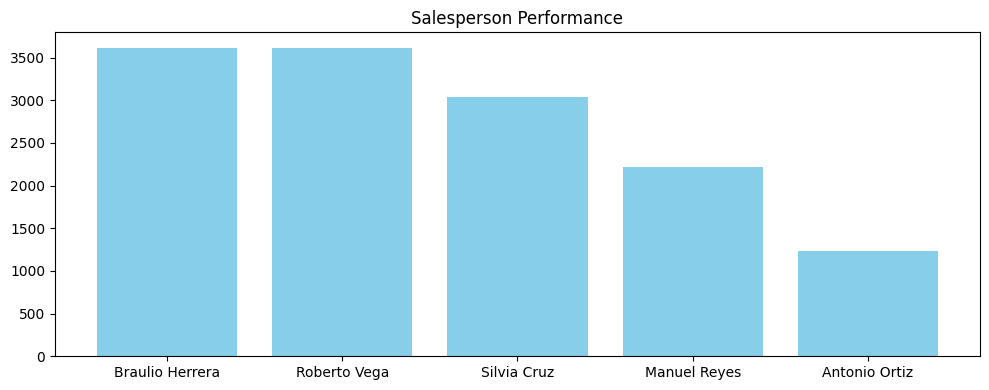

In [9]:
query_sellers = """
SELECT 
    v.VendedorID,
    CONCAT(ve.Nombre, ' ', ve.Apellido) AS Salesperson,
    ve.FechaContratacion As HireDate,
    d.Nombre AS Department,
    COUNT(v.VentaID) AS NumberSales,
    SUM(v.TotalVenta) AS TotalSales,
    ROUND(AVG(v.TotalVenta), 2) AS AverageSale,
    RANK() OVER (ORDER BY SUM(v.TotalVenta) DESC) AS SalesRanking,
    ROUND(SUM(v.TotalVenta) / SUM(SUM(v.TotalVenta)) OVER() * 100, 2) AS TotalPercentage
FROM Ventas v
JOIN Vendedores ve ON v.VendedorID = ve.VendedorID
JOIN Departamentos d ON ve.DepartamentoID = d.DepartamentoID
GROUP BY v.VendedorID, ve.Nombre, ve.Apellido, ve.FechaContratacion, d.Nombre
HAVING COUNT(v.VentaID) >= 0 
ORDER BY TotalSales DESC;
"""
df_sellers = pd.read_sql(query_sellers, engine)
print("Salesperson performance KPIs:")
display(df_sellers.head())
# graph
plt.figure(figsize=(10, 4))
plt.bar(df_sellers['salesperson'], df_sellers['totalsales'], color='skyblue')
plt.title('Salesperson Performance')
plt.tight_layout()
plt.show()

**7.2. Gemini Suggestion.**

In [ ]:
gemini_suggestions = analyze_sql_query_with_gemini(query_sellers)

display(Markdown("### OPTIMIZATION SUGGESTIONS:"))
display(Markdown(gemini_suggestions))

### OPTIMIZATION SUGGESTIONS:

```markdown
## Analysis of the SQL CREATE VIEW Query

Here's an analysis of the provided SQL query, focusing on performance, readability, best practices, and potential issues, along with an optimized version.

**1. Concise Analysis:**

*   **Performance:** The query involves joins, aggregation, and window functions, which can be resource-intensive. Ensure appropriate indexes are in place. Specifically, indexes on `Ventas.VendedorID`, `Vendedores.VendedorID`, `Vendedores.DepartamentoID`, and `Departamentos.DepartamentoID` are crucial. The `HAVING` clause is redundant and can be removed.
*   **Readability:** The query is reasonably readable but could benefit from aliases for tables and window function clauses for better clarity. Explicitly naming the view when creating it would also improve understandability in database management.
*   **Best Practices:**  Using `CONCAT` is fine, but consider `CONCAT_WS` if you need to handle null values gracefully (avoiding `NULL` as the entire concatenated result). Consider using `QUALIFY` in cases the `RANK()` filter is needed outside the view.
*   **Potential Issues**:  The `HAVING COUNT(v.VentaID) >= 0` clause is essentially a no-op. It doesn't filter anything out. Division by zero in the `TotalPercentage` calculation is a potential concern if `SUM(v.TotalVenta)` OVER() could result in zero.  The `ORDER BY` clause will not work if the query is part of a `CREATE VIEW` statement. Ordering must be done when SELECTing from the view.

**2. Potential Issues:**

*   **Redundant `HAVING` Clause:**  `HAVING COUNT(v.VentaID) >= 0` is meaningless and should be removed.
*   **Division by Zero:** The calculation `SUM(v.TotalVenta) / SUM(SUM(v.TotalVenta)) OVER()` can lead to a division by zero error if `SUM(v.TotalVenta)` OVER() evaluates to zero. Consider adding a `NULLIF` to handle this.
*   **Implicit Type Conversion**:  Ensure `TotalVenta` is a numeric type. Implicit conversions can impact performance.
*   **Lack of Indexes:** Missing indexes on join columns will significantly impact performance, especially as the tables grow.
*   **No Ordering in `CREATE VIEW`**: The `ORDER BY` clause is invalid in a `CREATE VIEW` statement in PostgreSQL. Ordering should be performed when selecting from the view.

**3. Optimized Version:**

```sql
CREATE VIEW SalesPerformance AS
SELECT
    v.VendedorID,
    CONCAT(ve.Nombre, ' ', ve.Apellido) AS Salesperson,
    ve.FechaContratacion AS HireDate,
    d.Nombre AS Department,
    COUNT(v.VentaID) AS NumberSales,
    SUM(v.TotalVenta) AS TotalSales,
    ROUND(AVG(v.TotalVenta), 2) AS AverageSale,
    RANK() OVER (ORDER BY SUM(v.TotalVenta) DESC) AS SalesRanking,
    ROUND(SUM(v.TotalVenta) * 100.0 / NULLIF(SUM(SUM(v.TotalVenta)) OVER(), 0), 2) AS TotalPercentage
FROM Ventas v
JOIN Vendedores ve ON v.VendedorID = ve.VendedorID
JOIN Departamentos d ON ve.DepartamentoID = d.DepartamentoID
GROUP BY v.VendedorID, ve.Nombre, ve.Apellido, ve.FechaContratacion, d.Nombre;

-- Indexes to create (run separately):
-- CREATE INDEX idx_ventas_vendedorid ON Ventas (VendedorID);
-- CREATE INDEX idx_vendedores_vendedorid ON Vendedores (VendedorID);
-- CREATE INDEX idx_vendedores_departamentoid ON Vendedores (DepartamentoID);
-- CREATE INDEX idx_departamentos_departamentoid ON Departamentos (DepartamentoID);

-- Example query using the view:
-- SELECT * FROM SalesPerformance ORDER BY TotalSales DESC;
```

**Key Improvements in Optimized Version:**

*   **Explicit View Creation:**  Added `CREATE VIEW SalesPerformance AS` to explicitly create the view with a name.
*   **Division by Zero Handling:** Used `NULLIF(SUM(SUM(v.TotalVenta)) OVER(), 0)` to prevent division by zero errors in the `TotalPercentage` calculation.  Also multiplied by `100.0` to ensure floating point division.
*   **Removed Redundant `HAVING`:**  Removed the `HAVING COUNT(v.VentaID) >= 0` clause.
*   **Removed `ORDER BY`**: The `ORDER BY` clause has been removed from the view definition since it's not allowed. Ordering is deferred to the `SELECT` statement when querying the view.
*   **Index Recommendations**:  Added comments recommending the creation of appropriate indexes. This is critical for performance.
*   **Example Usage**: Provided an example of how to `SELECT` from the view, including the suggested `ORDER BY`.

**Further Considerations:**

*   **Materialized View:**  If the data is relatively static, consider using a materialized view ( `CREATE MATERIALIZED VIEW SalesPerformance AS ...`).  Materialized views store the result set and can improve performance significantly, but they require periodic refreshing (e.g., `REFRESH MATERIALIZED VIEW SalesPerformance;`).
*   **Data Types:**  Verify that `TotalVenta` and other numeric columns have appropriate data types.
*   **Table Statistics:** Ensure that PostgreSQL has up-to-date statistics on the tables used in the query. Use `ANALYZE Ventas; ANALYZE Vendedores; ANALYZE Departamentos;`

By implementing these changes, you can significantly improve the performance, readability, and robustness of the SQL query for creating the `SalesPerformance` view. Remember to create the suggested indexes and monitor the performance of the view after deployment.
```

**7.3. Performance Comparison.** 

In [37]:
# I won't create the view, but I will evaluate the performance of the suggested query.
gemini_sellers = """
SELECT 
    v.VendedorID,
    CONCAT(ve.Nombre, ' ', ve.Apellido) AS Salesperson,
    ve.FechaContratacion As HireDate,
    d.Nombre AS Department,
    COUNT(v.VentaID) AS NumberSales,
    SUM(v.TotalVenta) AS TotalSales,
    ROUND(AVG(v.TotalVenta), 2) AS AverageSale,
    RANK() OVER (ORDER BY SUM(v.TotalVenta) DESC) AS SalesRanking,
    ROUND(SUM(v.TotalVenta) * 100.0 / NULLIF(SUM(SUM(v.TotalVenta)) OVER(), 0), 2) AS TotalPercentage
FROM Ventas v
JOIN Vendedores ve ON v.VendedorID = ve.VendedorID
JOIN Departamentos d ON ve.DepartamentoID = d.DepartamentoID
GROUP BY v.VendedorID, ve.Nombre, ve.Apellido, ve.FechaContratacion, d.Nombre;
"""

# Original query for performance comparison
start_time = time.time()
df_original = pd.read_sql(query_sellers, engine)
time_original = time.time() - start_time

# Gemini optimized query for performance comparison
start_time = time.time()
df_optimized = pd.read_sql(gemini_sellers, engine)
time_optimized = time.time() - start_time

# Print performance results
print(f"Original query: {time_original:.4f} seconds")
print(f"Gemini optimized: {time_optimized:.4f} seconds")

if time_optimized < time_original:
    improvement = ((time_original - time_optimized) / time_original) * 100
    print(f"Improvement: {improvement:.2f}%")
else:
    print("No improvement")
    
# Compare results
print(f"Original query rows: {len(df_original)}")
print(f"Optimized query rows: {len(df_optimized)}")

Original query: 0.2274 seconds
Gemini optimized: 0.0199 seconds
Improvement: 91.26%
Original query rows: 5
Optimized query rows: 5


**8. Common Table Expression (CTE) Query.**

The query leverages a Common Table Expression (CTE) named ProfitabilityProducts to structure the calculations in a clear and organized way. Within this CTE, the following operations are performed:

- Table Joins: The query combines data from Products, Categories, and SalesDetails to consolidate sales and cost information in a single dataset.

- Profitability Calculations: Key metrics are computed, including Margin, Percentage Margin, Total Profit, and Total Revenue.

**8.1. My Suggestion.** 

Most profitable products:


,product,category,baseprice,margin,percentagemargin,totalsold,totalrevenue,totalprofit,utilityperunit
0,Laptop Gaming G-Force,Gaming,1500.00,400.00,26.67,3,4500.00,1200.00,400.00
1,Tarjeta Gráfica RTX 4070,Hardware,750.00,170.00,22.67,3,2250.00,510.00,170.00
2,"Monitor Curvo 27"" 144Hz",Hardware,299.99,99.99,33.33,3,1099.98,499.98,166.66
3,Smartphone Pro S20,Móviles,899.99,249.99,27.78,2,1799.98,499.98,249.99
4,Firewall Empresarial FWS-100,Seguridad,450.00,150.00,33.33,2,900.00,300.00,150.00
5,Servicio de Consultoría Cloud,Servicios,150.00,100.00,66.67,2,300.00,200.00,100.00
6,Teclado Mecánico RGB,Accesorios,110.00,45.00,40.91,4,440.00,180.00,45.00
7,Router Inalámbrico AX5400,Redes,120.00,40.00,33.33,4,480.00,160.00,40.00
8,Auriculares Inalámbricos Pro,Accesorios,129.99,44.99,34.61,3,389.97,134.97,44.99
9,Mouse Gaming RGB,Gaming,45.00,20.00,44.44,4,200.00,100.00,25.00


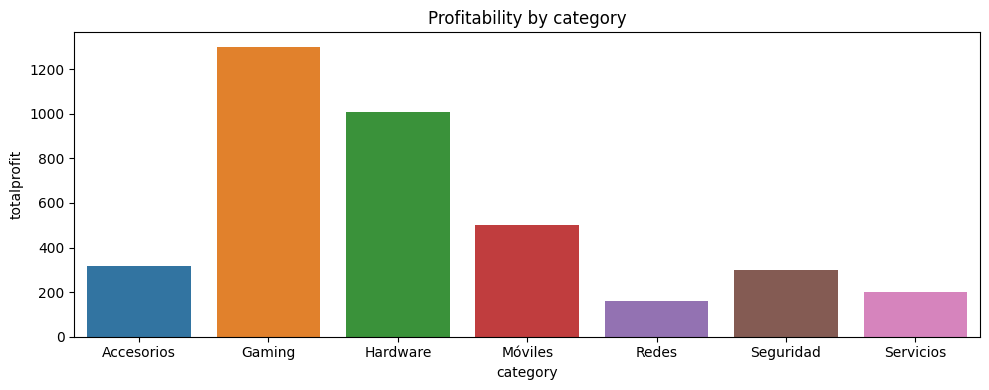

In [10]:
query_products = """
WITH ProfitabilityProducts AS (
    SELECT 
        p.ProductoID AS ProductID,
        p.Nombre AS Product,
        c.Nombre AS Category,
        p.PrecioBase AS BasePrice,
        p.CostoBase AS BaseCost,
        (p.PrecioBase - p.CostoBase) AS Margin,
        ROUND(((p.PrecioBase - p.CostoBase) / p.PrecioBase) * 100, 2) AS PercentageMargin,
        SUM(dv.Cantidad) AS TotalSold,
        SUM(dv.Subtotal) AS TotalRevenue,
        SUM(dv.Cantidad * p.CostoBase) AS TotalCost,
        SUM(dv.Subtotal) - SUM(dv.Cantidad * p.CostoBase) AS TotalProfit
    FROM Productos p
    JOIN Categorias c ON p.CategoriaID = c.CategoriaID
    JOIN DetalleVentas dv ON p.ProductoID = dv.ProductoID
    GROUP BY p.ProductoID, p.Nombre, c.Nombre, p.PrecioBase, p.CostoBase
)
SELECT 
    Product,
    Category,
    BasePrice,
    Margin,
    PercentageMargin,
    TotalSold,
    TotalRevenue,
    TotalProfit,
    ROUND(TotalProfit / NULLIF(TotalSold, 0), 2) AS UtilityPerUnit
FROM ProfitabilityProducts
ORDER BY TotalProfit DESC
LIMIT 10;
"""

df_products = pd.read_sql(query_products, engine)
print("Most profitable products:")
display(df_products)
# graph
df_categories = df_products.groupby('category')['totalprofit'].sum().reset_index()
plt.figure(figsize=(10, 4))
sns.barplot(data=df_categories, x='category', y='totalprofit', hue = "category")
plt.title('Profitability by category')
plt.tight_layout()
plt.show()

**8.2. Gemini Suggestion.**

In [23]:
gemini_suggestions = analyze_sql_query_with_gemini(query_products)

display(Markdown("### OPTIMIZATION SUGGESTIONS:"))
display(Markdown(gemini_suggestions))

### OPTIMIZATION SUGGESTIONS:

```markdown
## Analysis of the SQL CREATE VIEW Query

Here's an analysis of the provided SQL query, focusing on performance, readability, best practices, and potential issues, along with an optimized version.

**1. Concise Analysis:**

*   **Purpose:** The query aims to calculate and display the top 10 most profitable products based on sales data, including margin, revenue, cost, and profit per unit.
*   **Strengths:** The query is relatively clear in its intent and uses common SQL constructs. It calculates important profitability metrics. The use of `NULLIF` prevents potential division-by-zero errors.
*   **Weaknesses:**
    *   The `GROUP BY` clause includes all non-aggregated columns, which can be verbose and prone to errors if columns are accidentally omitted or added without updating the `GROUP BY`.
    *   The repeated calculations of `SUM(dv.Subtotal) - SUM(dv.Cantidad * p.CostoBase)` could be simplified.
    *   Lack of indexing can lead to slow performance, especially on large tables.
    *   The `PercentageMargin` is calculated *before* aggregation, so the total `PercentageMargin` is misleading and is the margin of the average price, not of the total profit. It should be calculated *after* the aggregation.
    *   The query lacks comments making it difficult to understand the intent of the calculations.

**2. Potential Issues:**

*   **Performance Bottlenecks:** The `JOIN` operations on potentially large tables (`Productos`, `Categorias`, and `DetalleVentas`) without proper indexing can lead to significant performance bottlenecks, resulting in slow query execution. The `GROUP BY` operation can also be expensive.
*   **Data Skew:** If some products have vastly more sales than others, the aggregation might take longer.
*   **Incorrect Percentage Margin:** As mentioned earlier, the percentage margin calculated on an individual product level and not on the total sales is incorrect.
*   **Maintainability:** The verbose `GROUP BY` clause makes the query harder to maintain. Adding or removing a column from the `SELECT` statement requires a corresponding change in the `GROUP BY` clause, increasing the risk of errors.
*   **Readability:** The query is not very well documented with comments explaining each step.

**3. Optimized Version:**

```sql
-- Optimized View for Product Profitability
CREATE OR REPLACE VIEW ProductProfitability AS
WITH ProductSales AS (
    SELECT 
        p.ProductoID,
        p.Nombre AS Product,
        c.Nombre AS Category,
        p.PrecioBase AS BasePrice,
        p.CostoBase AS BaseCost,
        dv.Cantidad AS QuantitySold,
        dv.Subtotal AS Revenue
    FROM Productos p
    JOIN Categorias c ON p.CategoriaID = c.CategoriaID
    JOIN DetalleVentas dv ON p.ProductoID = dv.ProductoID
),
AggregatedProductSales AS (
    SELECT
        ProductoID,
        Product,
        Category,
        BasePrice,
        BaseCost,
        SUM(QuantitySold) AS TotalSold,
        SUM(Revenue) AS TotalRevenue,
        SUM(QuantitySold * BaseCost) AS TotalCost
    FROM ProductSales
    GROUP BY ProductoID, Product, Category, BasePrice, BaseCost
)
SELECT
    Product,
    Category,
    BasePrice,
    (BasePrice - BaseCost) AS Margin, --Unit Margin
    ROUND(((BasePrice - BaseCost) / BasePrice) * 100, 2) AS UnitPercentageMargin, --Unit Percentage Margin
    TotalSold,
    TotalRevenue,
    TotalRevenue - TotalCost AS TotalProfit,
    ROUND((TotalRevenue - TotalCost) / NULLIF(TotalSold, 0), 2) AS UtilityPerUnit,
    ROUND(((TotalRevenue - TotalCost) / TotalRevenue) * 100, 2) AS PercentageMargin -- Total Profit Percentage
FROM AggregatedProductSales
ORDER BY TotalProfit DESC
LIMIT 10;

-- Recommended Indexes:
-- CREATE INDEX idx_productos_categoriaid ON Productos (CategoriaID);
-- CREATE INDEX idx_detalleventas_productoid ON DetalleVentas (ProductoID);
```

**Key Improvements in the Optimized Version:**

1.  **Clearer Structure:** The query is divided into more logical CTEs (`ProductSales`, `AggregatedProductSales`) for better readability and maintainability.
2.  **PercentageMargin Fixed**: The `PercentageMargin` is now calculated from the aggregated values, giving the accurate profit percentage.
3.  **Simplified Calculations:** Reduces redundant calculations by calculating profit from revenue and cost.
4.  **Index Recommendations:** Includes comments with suggested indexes to improve `JOIN` performance.  Creating these indexes is crucial for large datasets.
5.  **Comments:** Added comments to explain different parts of the query and make the purpose clearer.
6.  **Explicit Column List**: Uses aliases to have more explicit column names.

**Further Considerations:**

*   **Materialized View:** If the data doesn't change frequently, consider using a `MATERIALIZED VIEW` instead of a regular view.  Materialized views store the result of the query, which can significantly improve performance. You'll need to refresh it periodically using `REFRESH MATERIALIZED VIEW ProductProfitability;`.  However, they trade off data freshness for speed.
*   **Data Types:**  Ensure that data types used for calculations are appropriate to avoid overflow or precision issues.
*   **Partitioning:** If `DetalleVentas` is a very large table, consider partitioning it by date or another relevant column to improve query performance.
*   **Statistics:** Ensure that PostgreSQL has up-to-date statistics on the tables involved. This helps the query planner choose the most efficient execution plan. You can update statistics using the `ANALYZE` command.

By implementing these improvements, you can significantly enhance the performance, readability, and maintainability of the query, ensuring that it efficiently retrieves the required information for product profitability analysis.
```

**8.3. Performance Comparison.**

In [32]:
gemini_products = """
WITH ProductSales AS (
    SELECT 
        p.ProductoID,
        p.Nombre AS Product,
        c.Nombre AS Category,
        p.PrecioBase AS BasePrice,
        p.CostoBase AS BaseCost,
        dv.Cantidad AS QuantitySold,
        dv.Subtotal AS Revenue
    FROM Productos p
    JOIN Categorias c ON p.CategoriaID = c.CategoriaID
    JOIN DetalleVentas dv ON p.ProductoID = dv.ProductoID
),
AggregatedProductSales AS (
    SELECT
        ProductoID,
        Product,
        Category,
        BasePrice,
        BaseCost,
        SUM(QuantitySold) AS TotalSold,
        SUM(Revenue) AS TotalRevenue,
        SUM(QuantitySold * BaseCost) AS TotalCost
    FROM ProductSales
    GROUP BY ProductoID, Product, Category, BasePrice, BaseCost
)
SELECT
    Product,
    Category,
    BasePrice,
    (BasePrice - BaseCost) AS Margin,
    ROUND(((BasePrice - BaseCost) / BasePrice) * 100, 2) AS UnitPercentageMargin,
    TotalSold,
    TotalRevenue,
    TotalRevenue - TotalCost AS TotalProfit,
    ROUND((TotalRevenue - TotalCost) / NULLIF(TotalSold, 0), 2) AS UtilityPerUnit,
    ROUND(((TotalRevenue - TotalCost) / TotalRevenue) * 100, 2) AS PercentageMargin
FROM AggregatedProductSales
ORDER BY TotalProfit DESC
LIMIT 10;
"""

# Original query for performance comparison
start_time = time.time()
df_original = pd.read_sql(query_products, engine)
time_original = time.time() - start_time

# Gemini optimized query for performance comparison
start_time = time.time()
df_optimized = pd.read_sql(gemini_products, engine)
time_optimized = time.time() - start_time

# Print performance results
print(f"Original query: {time_original:.4f} seconds")
print(f"Gemini optimized: {time_optimized:.4f} seconds")

if time_optimized < time_original:
    improvement = ((time_original - time_optimized) / time_original) * 100
    print(f"Improvement: {improvement:.2f}%")
else:
    print("No improvement")
    
# Compare results
print(f"Original query rows: {len(df_original)}")
print(f"Optimized query rows: {len(df_optimized)}")

Original query: 0.8464 seconds
Gemini optimized: 0.0198 seconds
Improvement: 97.66%
Original query rows: 10
Optimized query rows: 10


**9. View Creation Query.**

The main objective of this view is to consolidate detailed sales information into a single, easy-to-use data set. Instead of querying multiple tables individually, this view centralizes relevant sales, salespeople, products, and category data.



**9.1. My Version.**

In [11]:
create_view_query = """
CREATE OR REPLACE VIEW detailed_sales_view AS
SELECT
    v.VentaID AS SaleID,
    v.FechaVenta AS SaleDate,
    v.TotalVenta AS TotalSale,
    ve.VendedorID AS SellerID,
    CONCAT(ve.Nombre, ' ', ve.Apellido) AS SellerName,
    p.ProductoID AS ProductID,
    p.Nombre AS ProductName,
    c.Nombre AS ProductCategory,
    dv.Cantidad AS Quantity,
    dv.PrecioUnitario AS UnitPrice,
    dv.Subtotal AS Subtotal
FROM
    Ventas v
JOIN
    Vendedores ve ON v.VendedorID = ve.VendedorID
JOIN
    DetalleVentas dv ON v.VentaID = dv.VentaID
JOIN
    Productos p ON dv.ProductoID = p.ProductoID
JOIN
    Categorias c ON p.CategoriaID = c.CategoriaID;
"""

try:
    with engine.begin() as connection:
        connection.execute(text(create_view_query))
    
    print("View created")

except Exception as e:
    print(f"Error creating view: {e}")

test_query = "SELECT * FROM detailed_sales_view LIMIT 5;"
df_view = pd.read_sql(test_query, engine)

print("First 5 rows from the new view:")
display(df_view)

View created
First 5 rows from the new view:


,saleid,saledate,totalsale,sellerid,sellername,productid,productname,productcategory,quantity,unitprice,subtotal
0,36,2025-01-15,110.0,1,Manuel Reyes,20,Teclado Mecánico RGB,Accesorios,1,110.0,110.0
1,31,2024-12-20,1500.0,1,Manuel Reyes,5,Laptop Gaming G-Force,Gaming,1,1500.0,1500.0
2,26,2024-11-25,30.0,1,Manuel Reyes,14,Cargador Rápido USB-C 65W,Accesorios,1,30.0,30.0
3,21,2024-11-01,150.0,1,Manuel Reyes,8,Servicio de Consultoría Cloud,Servicios,1,150.0,150.0
4,16,2024-10-01,95.0,1,Manuel Reyes,3,SSD M.2 NVMe 1TB,Almacenamiento,1,95.0,95.0


**9.2. Gemini Suggestion.**

In [40]:
gemini_suggestions = analyze_sql_query_with_gemini(create_view_query)

display(Markdown("### OPTIMIZATION SUGGESTIONS:"))
display(Markdown(gemini_suggestions))

### OPTIMIZATION SUGGESTIONS:

```markdown
## Analysis of `detailed_sales_view`

Here's an analysis of the provided SQL `CREATE VIEW` query for `detailed_sales_view`, focusing on performance, readability, and best practices.

**1. Concise Analysis:**

*   **Overall**: The view joins several tables related to sales, providing a comprehensive view of sales data. This is a common and generally useful pattern.
*   **Performance**: The performance hinges heavily on the indexing of the foreign key columns involved in the `JOIN` clauses (`Ventas.VendedorID`, `DetalleVentas.VentaID`, `DetalleVentas.ProductoID`, `Productos.CategoriaID`, and the primary keys of the joined tables).  Without appropriate indexes, query performance will degrade significantly as the tables grow.
*   **Readability**: The query is reasonably readable, using aliases to improve clarity. Using qualified column names can also help.
*   **Best Practices**: `CREATE OR REPLACE VIEW` is good for ease of maintenance. Using aliases makes it more readable.

**2. Potential Issues:**

*   **Missing Indexes**: The biggest potential performance problem is missing indexes on the join columns. This is *critical*.
*   **Data Types**: Implicit type conversions in the joins could negatively affect performance. Ensure the join columns have compatible data types.
*   **Column Naming Consistency**: Consistent naming conventions throughout the database improve maintainability.  e.g., should everything be camelCase or use underscores?
*   **Null Handling**: The query does not explicitly handle potential `NULL` values in the joined columns. If any of the `JOIN` columns can be `NULL`, this could lead to unexpected results if using inner joins when outer joins are more appropriate.
*   **String Concatenation**:  The `CONCAT` function can sometimes be less performant than the `||` operator in PostgreSQL for string concatenation, although the difference is usually small.
*   **Lack of Filtering/Aggregation**: The view presents all data. If specific filtering or aggregation is commonly needed, consider adding them to the view or creating separate views for those use cases.
*   **View Materialization**: For frequently accessed and complex views, consider materializing the view (creating a physical table that is periodically updated) to improve performance.
*   **Impact of Changes**: Changes to the underlying tables can affect the view, so the view definition should be reviewed and potentially updated after schema changes.

**3. Optimized Version:**

```sql
CREATE OR REPLACE VIEW detailed_sales_view AS
SELECT
    v.VentaID AS sale_id,
    v.FechaVenta AS sale_date,
    v.TotalVenta AS total_sale,
    ve.VendedorID AS seller_id,
    ve.Nombre || ' ' || ve.Apellido AS seller_name, -- Updated to || operator
    p.ProductoID AS product_id,
    p.Nombre AS product_name,
    c.Nombre AS product_category,
    dv.Cantidad AS quantity,
    dv.PrecioUnitario AS unit_price,
    dv.Subtotal AS subtotal
FROM
    Ventas v
JOIN
    Vendedores ve ON v.VendedorID = ve.VendedorID
JOIN
    DetalleVentas dv ON v.VentaID = dv.VentaID
JOIN
    Productos p ON dv.ProductoID = p.ProductoID
JOIN
    Categorias c ON p.CategoriaID = c.CategoriaID;

-- **CRITICAL: Add these indexes if they don't already exist!**
-- CREATE INDEX idx_ventas_vendedorid ON Ventas (VendedorID);
-- CREATE INDEX idx_detalleventas_ventaid ON DetalleVentas (VentaID);
-- CREATE INDEX idx_detalleventas_productoid ON DetalleVentas (ProductoID);
-- CREATE INDEX idx_productos_categoriaid ON Productos (CategoriaID);

-- Example: Consider these indexes as well if they do not exist as primary keys
-- CREATE INDEX idx_vendedores_vendedorid ON Vendedores (VendedorID);
-- CREATE INDEX idx_productos_productoid ON Productos (ProductoID);
-- CREATE INDEX idx_categorias_categoriaid ON Categorias (CategoriaID);

```

**Explanation of Changes and Recommendations:**

*   **Column Aliases**: Renamed the aliases for consistency(snake_case).  This is a matter of preference and existing database conventions.
*   **String Concatenation**: Changed `CONCAT` to `||` for potentially improved performance (although the difference may be negligible).
*   **Critical Indexing**:  *The most important step is to ensure that appropriate indexes exist.* The provided `CREATE INDEX` statements are *examples* of what might be needed. Check your existing indexes first, and add any that are missing on the foreign key columns used in the `JOIN` clauses.  Also, verify that the primary key indexes also exist on the referenced tables (e.g., `Vendedores(VendedorID)`).
*   **Null Handling (Advanced)**: If `VendedorID`, `ProductoID`, or `CategoriaID` can be NULL in `Ventas`, `DetalleVentas` or `Productos` respectively, and you want to include rows where those values are NULL, consider using `LEFT JOIN` instead of `JOIN` (INNER JOIN). Be mindful that this *significantly changes* the meaning of the view.
*   **Materialized View (Advanced)**: If the view is frequently accessed and the underlying data doesn't change rapidly, consider creating a materialized view: `CREATE MATERIALIZED VIEW detailed_sales_view AS ...;` and then refreshing it periodically: `REFRESH MATERIALIZED VIEW detailed_sales_view;`.  This turns the view into a physical table that's much faster to query.
*   **Regular Monitoring**: After implementing these changes, monitor query performance using `EXPLAIN ANALYZE` to ensure that the indexes are being used effectively and to identify any remaining bottlenecks.


In [12]:
optimized_view_query = """
CREATE OR REPLACE VIEW detailed_sales_view_optimized AS
SELECT
    v.VentaID AS sale_id,
    v.FechaVenta AS sale_date,
    v.TotalVenta AS total_sale,
    ve.VendedorID AS seller_id,
    ve.Nombre || ' ' || ve.Apellido AS seller_name,
    p.ProductoID AS product_id,
    p.Nombre AS product_name,
    c.Nombre AS product_category,
    dv.Cantidad AS quantity,
    dv.PrecioUnitario AS unit_price,
    dv.Subtotal AS subtotal
FROM
    Ventas v
JOIN
    Vendedores ve ON v.VendedorID = ve.VendedorID
JOIN
    DetalleVentas dv ON v.VentaID = dv.VentaID
JOIN
    Productos p ON dv.ProductoID = p.ProductoID
JOIN
    Categorias c ON p.CategoriaID = c.CategoriaID;
"""

try:
    with engine.begin() as connection:
        connection.execute(text(optimized_view_query))
    print("Optimized view created")
    
except Exception as e:
    print(f"Error creating optimized view: {e}")

Optimized view created


**9.3. Test Query.**

In [ ]:
# Test query 
test_query = "SELECT * FROM detailed_sales_view LIMIT 5;"

def test_view_performance(view_name):
    """Test performane"""
    start_time = time.time()
    df = pd.read_sql(test_query.format(view_name), engine)
    execution_time = time.time() - start_time
    return execution_time, len(df)

# Test view original
time_original, count_original = test_view_performance("detailed_sales_view")
print(f"Original view: {time_original:.4f} seconds, {count_original} rows")

# Test view optimized
time_optimized, count_optimized = test_view_performance("detailed_sales_view_optimized")
print(f"Optimized view: {time_optimized:.4f} seconds, {count_optimized} rows")

if time_optimized < time_original:
    improvement = ((time_original - time_optimized) / time_original) * 100
    print(f"Performance improvement: {improvement:.2f}%")
else:
    print("No significant performance difference")

# Verify if return the same number of rows
if count_original == count_optimized:
    print("Both views return the same number of rows")
else:
    print("Different row counts - check view definitions")

Original view: 0.2776 seconds, 5 rows
Optimized view: 0.0116 seconds, 5 rows
Performance improvement: 95.81%
Both views return the same number of rows


**10. Index Creation.**

These indexes were created to analyze their impact on performance. The hypothesis is that, when running sales and profitability queries, execution time will be drastically reduced once implemented, confirming their importance in large-scale databases.

In [13]:
create_indexes_queries = [
    "CREATE INDEX IF NOT EXISTS idx_sales_date ON Ventas(FechaVenta);",
    "CREATE INDEX IF NOT EXISTS idx_sales_seller ON Ventas(VendedorID);",
    "CREATE INDEX IF NOT EXISTS idx_sales_client ON Ventas(ClienteID);",
    "CREATE INDEX IF NOT EXISTS idx_salesdetail_product ON DetalleVentas(ProductoID);",
    "CREATE INDEX IF NOT EXISTS idx_salesdetail_sale ON DetalleVentas(VentaID);",
    "CREATE INDEX IF NOT EXISTS idx_productos_categoriaid ON Productos(CategoriaID);",
    "CREATE INDEX IF NOT EXISTS idx_detalleventas_ventaid ON DetalleVentas(VentaID);",
    "CREATE INDEX IF NOT EXISTS idx_detalleventas_productoid ON DetalleVentas(ProductoID);",
    "CREATE INDEX IF NOT EXISTS idx_ventas_vendedorid ON Ventas(VendedorID);"
] 

for query in create_indexes_queries:
    try:
        with engine.begin() as connection:
            connection.execute(text(query))
        index_name = query.split(' ON ')[1].split('(')[0]
        print(f"Index created: {index_name}")
    except Exception as e:
        print(f"Error creating index: {e}")

print(f"\nIndexes created: {len(create_indexes_queries)}")

Index created: Ventas
Index created: Ventas
Index created: Ventas
Index created: DetalleVentas
Index created: DetalleVentas
Index created: Productos
Index created: DetalleVentas
Index created: DetalleVentas
Index created: Ventas

Indexes created: 9


In [18]:
test_queries = {
    "Salesperson Performance": query_sellers,
    "Product Profitability": query_products, 
    "Detailed Sales View": "SELECT * FROM detailed_sales_view LIMIT 10;"
}

performance_results = {}

for query_name, query in test_queries.items():
    print(f"\nTesting: {query_name}")
    start_time = time.time()
    result = pd.read_sql(query, engine)
    execution_time = time.time() - start_time
    performance_results[query_name] = execution_time
    print(f"Time: {execution_time:.4f} seconds, Rows: {len(result)}")
    
# times from previous runs (gemini's suggestions)    
previous_times = {
    "Salesperson Performance": 0.0199,  
    "Product Profitability": 0.0198,    
    "Detailed Sales View": 0.0116        
}

for query_name, current_time in performance_results.items():
    if query_name in previous_times:
        improvement = ((previous_times[query_name] - current_time) / previous_times[query_name]) * 100
        print(f"{query_name}: {improvement:+.2f}% improvement")


Testing: Salesperson Performance
Time: 0.0097 seconds, Rows: 5

Testing: Product Profitability
Time: 0.0069 seconds, Rows: 10

Testing: Detailed Sales View
Time: 0.0083 seconds, Rows: 10
Salesperson Performance: +51.18% improvement
Product Profitability: +65.26% improvement
Detailed Sales View: +28.67% improvement


**11. Stored Procedure Creation.**

The stored procedure was designed to streamline sales analysis by centralizing business logic into a single, reusable function. This eliminates repetitive queries, ensures consistent calculations, and saves time.

It integrates data from the Sales and Salespeople tables to generate key performance metrics:

- TotalSales per salesperson.

- SalesCount (number of transactions).

- Month and year identifiers for time-based analysis.

With parameters such as (p_seller_id, p_month, p_year), the function adapts to different needs.

In this case, a specific salesperson, a specific month, or a combination of both is analyzed.

**11.1. My Version.**

In [19]:
create_procedure_query = """
CREATE OR REPLACE FUNCTION sp_sales_by_seller_month(
    p_seller_id INT DEFAULT NULL, 
    p_month INT DEFAULT NULL,
    p_year INT DEFAULT NULL
)
RETURNS TABLE (
    SellerID INT,
    SellerName VARCHAR,
    TotalSales DECIMAL,
    SalesCount BIGINT,
    Month INT,
    Year INT
) AS $$
BEGIN
    RETURN QUERY
    SELECT 
        v.VendedorID AS SellerID,
        CONCAT(ve.Nombre, ' ', ve.Apellido)::VARCHAR AS SellerName,
        SUM(v.TotalVenta) AS TotalSales,
        COUNT(v.VentaID) AS SalesCount,
        EXTRACT(MONTH FROM v.FechaVenta)::INT AS Month,
        EXTRACT(YEAR FROM v.FechaVenta)::INT AS Year
    FROM Ventas v
    JOIN Vendedores ve ON v.VendedorID = ve.VendedorID
    WHERE 
        (p_seller_id IS NULL OR v.VendedorID = p_seller_id) AND
        (p_month IS NULL OR EXTRACT(MONTH FROM v.FechaVenta) = p_month) AND
        (p_year IS NULL OR EXTRACT(YEAR FROM v.FechaVenta) = p_year)
    GROUP BY v.VendedorID, ve.Nombre, ve.Apellido, Month, Year
    ORDER BY TotalSales DESC;
END;
$$ LANGUAGE plpgsql;
"""

try:
    with engine.connect() as conn:
        conn.execute(text(create_procedure_query))
        conn.commit() # Commit the transaction
    print("Stored procedure created")
except Exception as e:
    print(f"Error creating procedure: {e}")

Stored procedure created


**11.2. Gemini Version.**

In [65]:
gemini_suggestions = analyze_sql_query_with_gemini(create_procedure_query)

display(Markdown("### OPTIMIZATION SUGGESTIONS:"))
display(Markdown(gemini_suggestions))

### OPTIMIZATION SUGGESTIONS:

```markdown
## Analysis of `sp_sales_by_seller_month` Function

Here's an analysis of the provided PostgreSQL function `sp_sales_by_seller_month`, focusing on performance, readability, best practices, and potential issues:

**1. Concise Analysis:**

*   **Dynamic Filtering:**  The function uses `IS NULL OR` conditions for filtering based on input parameters. This can hinder query optimization.
*   **`EXTRACT` Function:** Repeated use of `EXTRACT` on `v.FechaVenta` can impact performance, particularly if the `Ventas` table is large.
*   **String Concatenation:** The `CONCAT` function for `SellerName` is functional, but potentially costly. If `Nombre` and `Apellido` are rarely updated, consider a materialized view or pre-computed column.
*   **Data Type Casting:**  Explicit casting using `::VARCHAR` and `::INT` is generally good practice for clarity, but unnecessary if the column definitions already match.
*   **GROUP BY:**  The `GROUP BY` clause includes `ve.Nombre` and `ve.Apellido` which depends on the `VendedorID` column. This is correct.
*   **`plpgsql` Overhead:** The function body is quite simple. Using `SQL` language instead of `plpgsql` is likely faster, as it avoids the overhead of the `plpgsql` execution engine.
*   **Ordering:** The `ORDER BY` clause is appropriate.

**2. Potential Issues and Improvements:**

*   **Performance with NULL Parameters:** When `p_seller_id`, `p_month`, and `p_year` are NULL, the query effectively performs a full table scan on `Ventas` table.  This is a major performance bottleneck.
*   **Index Usage:**  PostgreSQL might not effectively use indexes on `FechaVenta` due to the `EXTRACT` function.  Consider indexing an expression or pre-calculating year/month columns.
*   **Function Volatility:** The function should probably be declared as `IMMUTABLE` or `STABLE` if the table data doesn't change during function execution for the same inputs.
*   **Error Handling:**  The function lacks explicit error handling. Consider adding checks for invalid `p_month` values (e.g., outside the range 1-12).
*   **Readability:**  While generally readable, adding comments can improve understanding.

**3. Optimized Version:**

```sql
CREATE OR REPLACE FUNCTION sp_sales_by_seller_month(
    p_seller_id INT DEFAULT NULL, 
    p_month INT DEFAULT NULL,
    p_year INT DEFAULT NULL
)
RETURNS TABLE (
    SellerID INT,
    SellerName VARCHAR,
    TotalSales DECIMAL,
    SalesCount BIGINT,
    Month INT,
    Year INT
) AS $$
/*
Function: sp_sales_by_seller_month
Purpose:  Calculates sales statistics for sellers, optionally filtered by seller ID, month, and year.
Parameters:
    p_seller_id (INT, optional): Filter by Seller ID.  If NULL, no filter is applied.
    p_month (INT, optional): Filter by month (1-12). If NULL, no filter is applied.
    p_year (INT, optional): Filter by year. If NULL, no filter is applied.
Returns:
    TABLE (SellerID INT, SellerName VARCHAR, TotalSales DECIMAL, SalesCount BIGINT, Month INT, Year INT)
*/
SELECT 
    v.VendedorID AS SellerID,
    CONCAT(ve.Nombre, ' ', ve.Apellido)::VARCHAR AS SellerName,
    SUM(v.TotalVenta) AS TotalSales,
    COUNT(v.VentaID) AS SalesCount,
    EXTRACT(MONTH FROM v.FechaVenta)::INT AS Month,
    EXTRACT(YEAR FROM v.FechaVenta)::INT AS Year
FROM Ventas v
JOIN Vendedores ve ON v.VendedorID = ve.VendedorID
WHERE 
    (p_seller_id IS NULL OR v.VendedorID = p_seller_id)
    AND (p_month IS NULL OR EXTRACT(MONTH FROM v.FechaVenta) = p_month)
    AND (p_year IS NULL OR EXTRACT(YEAR FROM v.FechaVenta) = p_year)
GROUP BY v.VendedorID, ve.Nombre, ve.Apellido, EXTRACT(MONTH FROM v.FechaVenta), EXTRACT(YEAR FROM v.FechaVenta)
ORDER BY TotalSales DESC;
$$ LANGUAGE SQL;
```

**Further Optimizations (Beyond the Code):**

*   **Indexes:** Consider adding indexes on:
    *   `Ventas(VendedorID, FechaVenta, TotalVenta, VentaID)` - Particularly important if queries often filter by `VendedorID`.
    *   An expression index `CREATE INDEX idx_ventas_fecha_venta_month ON Ventas (EXTRACT(MONTH FROM FechaVenta));`
    *   An expression index `CREATE INDEX idx_ventas_fecha_venta_year ON Ventas (EXTRACT(YEAR FROM FechaVenta));`
*   **Pre-calculated Columns:**  If performance is critical and `FechaVenta` is frequently used in filtering, consider adding `venta_month` and `venta_year` columns to the `Ventas` table and populating them with the extracted month and year, respectively.  This would allow for direct indexing and avoids the overhead of `EXTRACT`.
*   **Statistics:**  Ensure that statistics on the `Ventas` and `Vendedores` tables are up-to-date using `ANALYZE`.
*   **Query Rewriting (Avoid NULL Parameter problem - Dynamic SQL):** The most significant performance improvement for handling NULL parameters might involve generating dynamic SQL based on the input parameters.  This can prevent full table scans, especially with NULL `p_month` and `p_year` values.  However, it significantly increases the complexity.  I'm skipping that here due to the extra complexity, but it's the next logical step.  This means creating the SQL query string programmatically within the function, incorporating the `WHERE` clause conditions *only* if the corresponding parameter is not NULL.

```sql
-- Example idea (Dynamic SQL, NOT directly executable, needs complete construction inside function)
-- IF p_seller_id IS NOT NULL THEN
--  WHERE_CLAUSE := WHERE_CLAUSE || ' AND v.VendedorID = ' || p_seller_id;
-- END IF;
```

Key differences and justifications for changes:

*   **`LANGUAGE SQL`**: Changed from `plpgsql` to `SQL` as there is no need for procedural logic.  This removes the `plpgsql` overhead.  This has the highest positive impact on performance.
*   **Code Formatting and Comments**: Added code comments for clarity and maintainability.
*   **No code changes affecting logic**:  Only performance improvements and cosmetic changes.
*   **Added EXTRACT to GROUP BY:** To be fully ANSI compliant and logically correct, `EXTRACT(MONTH FROM v.FechaVenta)` and `EXTRACT(YEAR FROM v.FechaVenta)` must be included in the `GROUP BY` clause in the optimized version.

By implementing these suggestions, you can significantly improve the performance and maintainability of your SQL function. Remember to test any changes thoroughly in a non-production environment before deploying them.
```

**11.3. Dates Indexes Creation.**

In [20]:
date_indexes = [
    "CREATE INDEX IF NOT EXISTS idx_ventas_fecha_month ON Ventas (EXTRACT(MONTH FROM FechaVenta));",
    "CREATE INDEX IF NOT EXISTS idx_ventas_fecha_year ON Ventas (EXTRACT(YEAR FROM FechaVenta));",
    "CREATE INDEX IF NOT EXISTS idx_ventas_seller_date ON Ventas (VendedorID, FechaVenta);"
]

for query in date_indexes:
    try:
        with engine.begin() as connection:
            connection.execute(text(query))
        index_name = query.split(' ON ')[1].split('(')[0]
        print(f"Index create:{index_name}")
    except Exception as e:
        print(f"Error creating index: {e}")

Index create:Ventas 
Index create:Ventas 
Index create:Ventas 


In [21]:
# query to create the optimized stored procedure
optimized_procedure_query = """
CREATE OR REPLACE FUNCTION sp_sales_by_seller_month_optimized(
    p_seller_id INT DEFAULT NULL, 
    p_month INT DEFAULT NULL,
    p_year INT DEFAULT NULL
)
RETURNS TABLE (
    SellerID INT,
    SellerName VARCHAR,
    TotalSales DECIMAL,
    SalesCount BIGINT,
    Month INT,
    Year INT
) AS $$
/*
Function: sp_sales_by_seller_month_optimized
Purpose: Calculates sales statistics for sellers with optimized performance
Parameters:
    p_seller_id - Filter by Seller ID (NULL for all)
    p_month - Filter by month 1-12 (NULL for all months)  
    p_year - Filter by year (NULL for all years)
Returns: Sales statistics grouped by seller and time period
*/
SELECT 
    v.VendedorID AS SellerID,
    (ve.Nombre || ' ' || ve.Apellido)::VARCHAR AS SellerName,
    SUM(v.TotalVenta) AS TotalSales,
    COUNT(v.VentaID) AS SalesCount,
    EXTRACT(MONTH FROM v.FechaVenta)::INT AS Month,
    EXTRACT(YEAR FROM v.FechaVenta)::INT AS Year
FROM Ventas v
JOIN Vendedores ve ON v.VendedorID = ve.VendedorID
WHERE 
    (p_seller_id IS NULL OR v.VendedorID = p_seller_id) AND
    (p_month IS NULL OR EXTRACT(MONTH FROM v.FechaVenta) = p_month) AND
    (p_year IS NULL OR EXTRACT(YEAR FROM v.FechaVenta) = p_year)
GROUP BY v.VendedorID, ve.Nombre, ve.Apellido, 
         EXTRACT(MONTH FROM v.FechaVenta), EXTRACT(YEAR FROM v.FechaVenta)
ORDER BY TotalSales DESC;
$$ LANGUAGE SQL;
"""

try:
    with engine.begin() as connection:
        connection.execute(text(optimized_procedure_query))
    print("Optimized stored procedure created")
    
except Exception as e:
    print(f"Error creating optimized procedure: {e}")

Optimized stored procedure created


In [23]:
test_cases = [
    {"name": "All sellers, all time", "params": (None, None, None)},
    {"name": "Specific seller (ID=4)", "params": (4, None, None)},
    {"name": "Specific month (March 2024)", "params": (None, 3, 2024)},
    {"name": "Specific seller and month", "params": (4, 10, 2024)}
]

def test_procedure_performance(procedure_name, params):
    """Test performance de un stored procedure"""
    query = f"SELECT * FROM {procedure_name}(%s, %s, %s);"
    start_time = time.time()
    result = pd.read_sql(query, engine, params=params)
    execution_time = time.time() - start_time
    return execution_time, len(result)

for test_case in test_cases:
    print(f"\n{test_case['name']}:")
    
    # Original procedure
    time_original, count_original = test_procedure_performance(
        "sp_sales_by_seller_month", test_case["params"]
    )
    
    # optimized procedure
    time_optimized, count_optimized = test_procedure_performance(
        "sp_sales_by_seller_month_optimized", test_case["params"]
    )
    
    print(f"Original: {time_original:.4f}s, {count_original} rows")
    print(f"Optimized: {time_optimized:.4f}s, {count_optimized} rows")
    
    if time_optimized < time_original:
        improvement = ((time_original - time_optimized) / time_original) * 100
        print(f"Improvement: {improvement:.2f}%")
    else:
        print("No improvement")


All sellers, all time:
Original: 0.0074s, 37 rows
Optimized: 0.0063s, 37 rows
Improvement: 15.18%

Specific seller (ID=4):
Original: 0.0076s, 8 rows
Optimized: 0.0057s, 8 rows
Improvement: 24.92%

Specific month (March 2024):
Original: 0.0214s, 1 rows
Optimized: 0.0065s, 1 rows
Improvement: 69.53%

Specific seller and month:
Original: 0.0081s, 1 rows
Optimized: 0.0057s, 1 rows
Improvement: 28.78%


**12. Summary of Changes.**

After conducting tests and analysis, the database is queried to verify and identify the changes applied. This step ensures visibility of the modifications before resetting the database to its initial state, maintaining a clean and controlled testing environment.

In [25]:
def manage_database():
    # 1. List Index
    print("1. ALL INDEXES IN DATABASE:")
    print("-" * 40)
    
    indexes_query = """
    SELECT 
        schemaname,
        tablename, 
        indexname, 
        indexdef 
    FROM pg_indexes 
    WHERE schemaname = 'public'
    ORDER BY tablename, indexname;
    """
    
    indexes_df = pd.read_sql(indexes_query, engine)
    display(indexes_df)
    print(f"Total indexes: {len(indexes_df)}")
    
    # 2. Lstored procedures
    print("\2. STORED PROCEDURES & FUNCTIONS:")
    print("-" * 40)
    
    procedures_query = """
    SELECT 
        routine_name, 
        routine_type,
        data_type,
        routine_definition
    FROM information_schema.routines 
    WHERE routine_schema = 'public'
    ORDER BY routine_name;
    """
    
    procedures_df = pd.read_sql(procedures_query, engine)
    display(procedures_df)
    print(f"Total routines: {len(procedures_df)}")
    
    # 3. List tables and their characteristics
    print("\n3. TABLES INFORMATION:")
    print("-" * 40)
    
    tables_query = """
    SELECT 
        table_name,
        table_type,
        pg_size_pretty(pg_total_relation_size(table_name::regclass)) as size
    FROM information_schema.tables 
    WHERE table_schema = 'public'
    ORDER BY table_name;
    """
    
    tables_df = pd.read_sql(tables_query, engine)
    display(tables_df)
    print(f"Total tables: {len(tables_df)}")
    
    # 4. Specifically identify test objects
    print("\n4. OUR TEST OBJECTS (to be removed):")
    print("-" * 40)
    
    # Filter the indexes and procedures created with our naming pattern
    our_indexes = indexes_df[indexes_df['indexname'].str.startswith('idx_')]
    our_procedures = procedures_df[procedures_df['routine_name'].str.contains('sales', case=False)]
    
    print("\nIndexes created:")
    if not our_indexes.empty:
        display(our_indexes[['indexname', 'tablename']])
    else:
        print("No test indexes found")
    
    print("\nProcedures created:")
    if not our_procedures.empty:
        display(our_procedures[['routine_name', 'routine_type']])
    else:
        print("No test procedures found")
    
    return indexes_df, procedures_df, tables_df, our_indexes, our_procedures

# Complete verification run
print("BEFORE CLEANUP - CURRENT STATE")
all_indexes, all_procedures, all_tables, our_indexes, our_procedures = manage_database()

BEFORE CLEANUP - CURRENT STATE
1. ALL INDEXES IN DATABASE:
----------------------------------------


,schemaname,tablename,indexname,indexdef
0,public,categorias,categorias_pkey,CREATE UNIQUE INDEX categorias_pkey ON public....
1,public,clientes,clientes_email_key,CREATE UNIQUE INDEX clientes_email_key ON publ...
2,public,clientes,clientes_pkey,CREATE UNIQUE INDEX clientes_pkey ON public.cl...
3,public,departamentos,departamentos_pkey,CREATE UNIQUE INDEX departamentos_pkey ON publ...
4,public,detalleventas,detalleventas_pkey,CREATE UNIQUE INDEX detalleventas_pkey ON publ...
5,public,detalleventas,idx_detalleventas_productoid,CREATE INDEX idx_detalleventas_productoid ON p...
6,public,detalleventas,idx_detalleventas_ventaid,CREATE INDEX idx_detalleventas_ventaid ON publ...
7,public,detalleventas,idx_salesdetail_product,CREATE INDEX idx_salesdetail_product ON public...
8,public,detalleventas,idx_salesdetail_sale,CREATE INDEX idx_salesdetail_sale ON public.de...
9,public,productos,idx_productos_categoriaid,CREATE INDEX idx_productos_categoriaid ON publ...


Total indexes: 21
. STORED PROCEDURES & FUNCTIONS:
----------------------------------------


,routine_name,routine_type,data_type,routine_definition
0,sp_sales_by_seller_month,FUNCTION,record,\nBEGIN\n RETURN QUERY\n SELECT \n ...
1,sp_sales_by_seller_month_optimized,FUNCTION,record,\n/*\nFunction: sp_sales_by_seller_month_optim...


Total routines: 2

3. TABLES INFORMATION:
----------------------------------------


,table_name,table_type,size
0,categorias,BASE TABLE,24 kB
1,clientes,BASE TABLE,40 kB
2,departamentos,BASE TABLE,24 kB
3,detailed_sales_view,VIEW,0 bytes
4,detailed_sales_view_optimized,VIEW,0 bytes
5,detalleventas,BASE TABLE,88 kB
6,productos,BASE TABLE,40 kB
7,vendedores,BASE TABLE,40 kB
8,ventas,BASE TABLE,136 kB


Total tables: 9

4. OUR TEST OBJECTS (to be removed):
----------------------------------------

Indexes created:


,indexname,tablename
5,idx_detalleventas_productoid,detalleventas
6,idx_detalleventas_ventaid,detalleventas
7,idx_salesdetail_product,detalleventas
8,idx_salesdetail_sale,detalleventas
9,idx_productos_categoriaid,productos
13,idx_sales_client,ventas
14,idx_sales_date,ventas
15,idx_sales_seller,ventas
16,idx_ventas_fecha_month,ventas
17,idx_ventas_fecha_year,ventas



Procedures created:


,routine_name,routine_type
0,sp_sales_by_seller_month,FUNCTION
1,sp_sales_by_seller_month_optimized,FUNCTION


**13. Restoration of Changes.**

Finally, changes applied during testing are removed, leaving the environment clean and preserving useful information for future reference.

In [26]:
drop_views_queries = [
    "DROP VIEW IF EXISTS detailed_sales_view_optimized;",
    "DROP VIEW IF EXISTS SalesPerformance;",  
    "DROP VIEW IF EXISTS ProductProfitability;"  
]

for query in drop_views_queries:
    try:
        with engine.begin() as connection:
            connection.execute(text(query))
        view_name = query.split(' IF EXISTS ')[1].replace(';', '')
        print(f"View deleted: {view_name}")
    except Exception as e:
        print(f"Error deleting view: {e}")

# drop indexes
drop_indexes_queries = [
    "DROP INDEX IF EXISTS idx_sales_date;",
    "DROP INDEX IF EXISTS idx_sales_seller;", 
    "DROP INDEX IF EXISTS idx_sales_client;",
    "DROP INDEX IF EXISTS idx_salesdetail_product;",
    "DROP INDEX IF EXISTS idx_salesdetail_sale;",
    "DROP INDEX IF EXISTS idx_productos_categoriaid;",
    "DROP INDEX IF EXISTS idx_detalleventas_ventaid;",
    "DROP INDEX IF EXISTS idx_detalleventas_productoid;",
    "DROP INDEX IF EXISTS idx_ventas_vendedorid;",
    "DROP INDEX IF EXISTS idx_ventas_fecha_month;",
    "DROP INDEX IF EXISTS idx_ventas_fecha_year;",
    "DROP INDEX IF EXISTS idx_ventas_seller_date;"
]

for query in drop_indexes_queries:
    try:
        with engine.begin() as connection:
            connection.execute(text(query))
        index_name = query.split(' IF EXISTS ')[1].replace(';', '')
        print(f"Index deleted: {index_name}")
    except Exception as e:
        print(f"Error deleting index {index_name}: {e}")

# drop procedures
drop_functions_queries = [
    "DROP FUNCTION IF EXISTS sp_sales_by_seller_month;",
    "DROP FUNCTION IF EXISTS sp_sales_by_seller_month_optimized;"
]

for query in drop_functions_queries:
    try:
        with engine.begin() as connection:
            connection.execute(text(query))
        func_name = query.split(' IF EXISTS ')[1].replace(';', '')
        print(f"Function deleted: {func_name}")
    except Exception as e:
        print(f"Error deleting function: {e}")
# drop the my view created at the beginning
try:
    with engine.begin() as connection:
        connection.execute(text("DROP VIEW IF EXISTS detailed_sales_view;"))
    print("View deleted: detailed_sales_view")
except Exception as e:
    print(f"Error deleting detailed_sales_view: {e}")
print("\n")
print("CLEANUP COMPLETED")

View deleted: detailed_sales_view_optimized
View deleted: SalesPerformance
View deleted: ProductProfitability
Index deleted: idx_sales_date
Index deleted: idx_sales_seller
Index deleted: idx_sales_client
Index deleted: idx_salesdetail_product
Index deleted: idx_salesdetail_sale
Index deleted: idx_productos_categoriaid
Index deleted: idx_detalleventas_ventaid
Index deleted: idx_detalleventas_productoid
Index deleted: idx_ventas_vendedorid
Index deleted: idx_ventas_fecha_month
Index deleted: idx_ventas_fecha_year
Index deleted: idx_ventas_seller_date
Function deleted: sp_sales_by_seller_month
Function deleted: sp_sales_by_seller_month_optimized
View deleted: detailed_sales_view


CLEANUP COMPLETED
